In [ ]:
import os, sys
from io import StringIO
RunningInCOLAB = 'google.colab' in str(get_ipython())

print("Downloading model this will only take a second!")
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout
        
with Capturing() as output:
  if RunningInCOLAB:
      print('Downloading packages')
      !pip install NEURON==8.0.0
      !pip install bmtk==0.0.9
      !pip install ipywidgets==7.7.1

  if os.path.basename(os.getcwd())!='3_cell_model':
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git
      %cd Fear-Lesson-Plans/3_cell_model/biophys_components/mechanisms/
      !nrnivmodl modfiles
      %cd ../..
      %ls
      print("model was downloaded!")
  else:
    try: #assuming your already in the 2 cell folder like on ur local machine
      %cd biophys_components/mechanisms/
      !nrnivmodl modfiles
      %cd ../..
      %ls
    except:
      pass
      print("model was already downloaded")

In [1]:
from bmtk.builder import NetworkBuilder
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.sim_setup import build_env_bionet
import numpy as np
import sys
import random
import shutil
import synapses
import warnings
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

if os.path.isdir('network'):
    shutil.rmtree('network')
if os.path.isdir('3_cell_inputs'):
    try:
        os.remove('3_cell_inputs/bg_pn_c_spikes.h5')
    except:
        pass
    try:
        os.remove('3_cell_inputs/bg_vip_spikes.h5')
    except:
        pass
    try:
        os.remove('3_cell_inputs/bg_olm_spikes.h5')
    except:
        pass

seed = 967
random.seed(seed)
np.random.seed(seed)

synapses.load()
syn = synapses.syn_params_dicts()

# Initialize our network

net = NetworkBuilder("biophysical")

num_inh = [1]

num_exc = [1]

##################################################################################
###################################BIOPHY#########################################

#PN
net.add_nodes(N=1, pop_name='PyrC',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:Cell_C',
              morphology=None)

#SOM
net.add_nodes(N=5, pop_name='SOM',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:SOM_Cell_old',
              morphology=None)

#VIP
net.add_nodes(N=5, pop_name='VIP',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:SOM_Cell_old',
              morphology=None)


backgroundPN_A = NetworkBuilder('bg_pn_c')
backgroundPN_A.add_nodes(N=1,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundVIP = NetworkBuilder('bg_vip')
backgroundVIP.add_nodes(N=5,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundSOM = NetworkBuilder('bg_som')
backgroundSOM.add_nodes(N=5,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')


# External excitatory inputs
tone = NetworkBuilder('tone')
tone.add_nodes(N=1,
               pop_name='tone',
               potential='exc',
               model_type='virtual')


def one_to_all(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting all cells")
    return 1

def SOM_to_PN(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting SOM to PN cell")
    return 1

def VIP_to_SOM(source, target):
    sid = source.node_id
    tid = target.node_id
    print("connecting VIP to SOM cell")
    return 1

def BG_to_PN_A(source, target):
    sid = source.node_id
    tid = target.node_id
    if sid == tid:
        #print("connecting BG {} to PN_C{}".format(sid,tid))
        return 1
    else:
        return 0
        
def BG_to_VIP(source, target):
    sid = source.node_id
    tid = target.node_id
    sid = sid + 6
    if sid == tid:
        print("connecting BG {} to VIP{}".format(sid,tid))
        return 1
    else:
        return 0

def BG_to_OLM(source, target):
    sid = source.node_id
    tid = target.node_id
    sid = sid + 1
    if sid == tid:
        print("connecting BG{} to SOM{}".format(sid,tid))
        return 1

def tone_to_cells(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting tone to {}".format(tid))
    return 1



conn = net.add_edges(source=net.nodes(pop_name='PyrC'), target=net.nodes(pop_name="SOM"),
              connection_rule=one_to_all,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2SOM.json',
              model_template=syn['PN2SOM.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float])

conn = net.add_edges(source=net.nodes(pop_name='SOM'), target=net.nodes(pop_name="PyrC"),
              connection_rule=SOM_to_PN,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='SOM2PN.json',
              model_template=syn['SOM2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.5), dtypes=[np.int32, np.float])

conn = net.add_edges(source=net.nodes(pop_name="VIP"), target=net.nodes(pop_name="SOM"),
              connection_rule=VIP_to_SOM,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='VIP2SOM.json',
              model_template=syn['VIP2SOM.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float])

#tone connections
conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name='PyrC'),
              connection_rule=tone_to_cells,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2PN.json',
              model_template=syn['tone2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name='VIP'),
              connection_rule=tone_to_cells,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2INT.json',
              model_template=syn['tone2INT.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9



###BACKGROUND CONNECTIONS###
conn = net.add_edges(source=backgroundPN_A.nodes(), target=net.nodes(pop_name='PyrC'),
              connection_rule=BG_to_PN_A,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PNC.json',
              model_template=syn['BG2PNC.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float]) # places syn on apic at 0.9

conn = net.add_edges(source=backgroundVIP.nodes(), target=net.nodes(pop_name='VIP'),
              connection_rule=BG_to_VIP,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2VIP.json',
              model_template=syn['BG2VIP.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float])

conn = net.add_edges(source=backgroundSOM.nodes(), target=net.nodes(pop_name='SOM'),
              connection_rule=BG_to_OLM,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2SOM.json',
              model_template=syn['BG2SOM.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float]) # places syn on basal at 0.9

#do save for all networks

net.build()
net.save(output_dir='network')

tone.build()
tone.save(output_dir='network')

backgroundPN_A.build()
backgroundPN_A.save_nodes(output_dir='network')

backgroundVIP.build()
backgroundVIP.save_nodes(output_dir='network')

backgroundSOM.build()
backgroundSOM.save_nodes(output_dir='network')

#SPIKE TRAINS
t_sim = 5000

build_env_bionet(base_dir='./',
                 network_dir='./network',
                 tstop=t_sim, dt=0.1,
                 report_vars=['v'],
                 components_dir='biophys_components',
                 config_file='config.json',
                 spikes_inputs=[('bg_pn_c', '3_cell_inputs/bg_pn_c_spikes.h5'),
                                ('bg_vip', '3_cell_inputs/bg_vip_spikes.h5'),
                                ('bg_som', '3_cell_inputs/bg_som_spikes.h5'),
                                ('tone', '3_cell_inputs/tone_spikes.csv'),],
                 compile_mechanisms=False)


psg = PoissonSpikeGenerator(population='bg_pn_c')
psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=0.0001,    # 1 spike every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('3_cell_inputs/bg_pn_c_spikes.h5')

print('Number of background spikes for PN_C: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_vip')
psg.add(node_ids=range(5),  # need same number as cells
        firing_rate=7.7,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('3_cell_inputs/bg_vip_spikes.h5')

print('Number of background spikes for PV: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_som')
psg.add(node_ids=range(5),  # need same number as cells
        firing_rate=8.5,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('3_cell_inputs/bg_som_spikes.h5')

print('Number of background spikes for OLM: {}'.format(psg.n_spikes()))


connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting VIP to SOM cell
connecting BG 6 to VIP6
connecting BG 7 to VIP7
connecting BG 8 to VIP8
connecting BG 9 to VIP9
connecting BG 10 to VIP10
connecting BG1 to SOM1
connecting BG2 to SOM2
connecting BG3 to SOM3
connecting BG4 to SOM4
connecting BG5 to SOM5
Number of background spikes for PN_C: 0
Number of background spikes for PV: 136
Number o

In [2]:
from ipywidgets import widgets, HBox, VBox
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from IPython.display import clear_output
from IPython.utils import io
import os, sys
import json
from bmtk.simulator import bionet
import numpy as np
import warnings
import random
from io import StringIO
import synapses
from neuron import h

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

slider1 = widgets.IntSlider(value=0, min=0, max=20, step=1,description="PN_input")
#Create your button.
button1 = widgets.Button(description="Generate")
output1 = widgets.Output()
slider2 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="VIP_input")
#Create your button.
button2 = widgets.Button(description="Generate")
output2 = widgets.Output()
button3 = widgets.Button(description="run_model")

slider4 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PN2PV")
#Create your button.
button4 = widgets.Button(description="Edit")
output4 = widgets.Output()

slider5 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="PV2PN")
#Create your button.
button5 = widgets.Button(description="Edit")
output5 = widgets.Output()

slider6 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="SOM_input")
#Create your button.
button6 = widgets.Button(description="Generate")
output6 = widgets.Output()

slider7 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="SOM2PN")
#Create your button.
button7 = widgets.Button(description="Edit")
output7 = widgets.Output()

slider8 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="TONE2PN")
#Create your button.
button8 = widgets.Button(description="Edit")
output8 = widgets.Output()

slider9 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="TONE2VIP")
#Create your button.
button9 = widgets.Button(description="Edit")
output9 = widgets.Output()

slider10 = widgets.IntSlider(value=5, min=0, max=20, step=1,description="VIP2SOM")
#Create your button.
button10 = widgets.Button(description="Edit")
output10 = widgets.Output()

#function to handle input.
def gen_bg_pn(btn):
    clear_output()
    output1.clear_output()
    return_value = slider1.value
    os.remove('3_cell_inputs/bg_pn_c_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_pn_c')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pn_c_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_pn_c')
        psg.add(node_ids=range(1),  # need same number as cells
            firing_rate=0.00001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_pn_c_spikes.h5')
    print('Generated background of PN at : {} Hz'.format(return_value))
    display(ui)
    #with output1:
        #print(return_value)
def gen_bg_pv(btn):
    clear_output()
    output2.clear_output()
    return_value = slider2.value
    os.remove('3_cell_inputs/bg_vip_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_vip')
        psg.add(node_ids=range(5),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_vip_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_vip')
        psg.add(node_ids=range(5),  # need same number as cells
            firing_rate=0.00001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_vip_spikes.h5')
    print('Generated background of VIP at : {} Hz'.format(return_value))
    display(ui)

def gen_bg_olm(btn):
    clear_output()
    output6.clear_output()
    return_value = slider6.value
    os.remove('3_cell_inputs/bg_som_spikes.h5')
    if return_value != 0:
        psg = PoissonSpikeGenerator(population='bg_som')
        psg.add(node_ids=range(5),  # need same number as cells
            firing_rate=return_value,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_som_spikes.h5')
    else:
        psg = PoissonSpikeGenerator(population='bg_som')
        psg.add(node_ids=range(5),  # need same number as cells
            firing_rate=0.000001,    # 1 spike every 1 second Hz
            times=(0.0, 40000/1000))  # time is in seconds for some reason
        psg.to_sonata('3_cell_inputs/bg_som_spikes.h5')
    print('Generated background of SOM at : {} Hz'.format(return_value))
    display(ui)
    
def change_PN2PV(btn):
    clear_output()
    output4.clear_output()
    return_value = slider4.value
    with open('biophys_components/synaptic_models/PN2PV.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PN2PV synaptic weight to {}".format(return_value))
    display(ui)
    

def change_PV2PN(btn):
    clear_output()
    output5.clear_output()
    return_value = slider5.value
    with open('biophys_components/synaptic_models/PV2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PV2PN synaptic weight to {}".format(return_value))
    display(ui)

def change_OLM2PN(btn):
    clear_output()
    output7.clear_output()
    return_value = slider7.value
    with open('biophys_components/synaptic_models/SOM2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed SOM2PN synaptic weight to {}".format(return_value))
    display(ui)
    
def change_tone2PN(btn):
    clear_output()
    output8.clear_output()
    return_value = slider8.value
    with open('biophys_components/synaptic_models/tone2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed tone2PN synaptic weight to {}".format(return_value))
    display(ui)
    
def change_tone2INT(btn):
    clear_output()
    output9.clear_output()
    return_value = slider9.value
    with open('biophys_components/synaptic_models/tone2INT.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed tone2PV synaptic weight to {}".format(return_value))
    display(ui)
    
def change_VIP2SOM(btn):
    clear_output()
    output10.clear_output()
    return_value = slider10.value
    with open('biophys_components/synaptic_models/VIP2SOM.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = (return_value) # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed VIP2SOM synaptic weight to {}".format(return_value))
    display(ui)

button1.on_click(gen_bg_pn)
button2.on_click(gen_bg_pv)
button4.on_click(change_PN2PV)
button5.on_click(change_PV2PN)
button6.on_click(gen_bg_olm)
button7.on_click(change_OLM2PN)
button8.on_click(change_tone2PN)
button9.on_click(change_tone2INT)
button10.on_click(change_VIP2SOM)
##do the same thing but change the weight in the json file but opening it and changing it might be a bitch but idk how else
def run_model(*args):
    clear_output()
    with Capturing() as output:
        synapses.load()
        h.nrnmpi_init()
        pc = h.ParallelContext()  # object to access MPI methods
        MPI_size = int(pc.nhost())
        MPI_rank = int(pc.id())


        config_file = 'config.json'



        conf = bionet.Config.from_json(config_file, validate=True);
        conf.build_env();

        graph = bionet.BioNetwork.from_config(conf);
        sim = bionet.BioSimulator.from_config(conf, network=graph);

        cells = graph.get_local_cells();

        sim.run();

        pc.barrier();
        pc.gid_clear()
        pc.done()
    display(ui)
button3.on_click(run_model)





ui = VBox([HBox([slider1, button1, slider6, button6,slider2, button2,]),
           HBox([slider7, button7,slider10,button10]),
           HBox([slider8, button8, slider9,button9]),
           button3])
ui


INFO:NEURONIOUtils:Created log file
INFO:NEURONIOUtils:Building cells.
INFO:NEURONIOUtils:Building recurrent connections
INFO:NEURONIOUtils:Building virtual cell stimulations for bg_pn_c_spikes
INFO:NEURONIOUtils:Building virtual cell stimulations for bg_vip_spikes
INFO:NEURONIOUtils:Building virtual cell stimulations for bg_som_spikes
INFO:NEURONIOUtils:Building virtual cell stimulations for tone_spikes
INFO:NEURONIOUtils:Running simulation for 5000.000 ms with the time step 0.100 ms
INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms
INFO:NEURONIOUtils:Block save every 5000 steps
INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms
INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms
INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms
INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms
INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms
INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms
INFO:NEURONIOUtils:    step:35000 t_sim:3500.00 ms
INFO:NEURONIOUtils:    step:40000 t_sim:4000.00 m

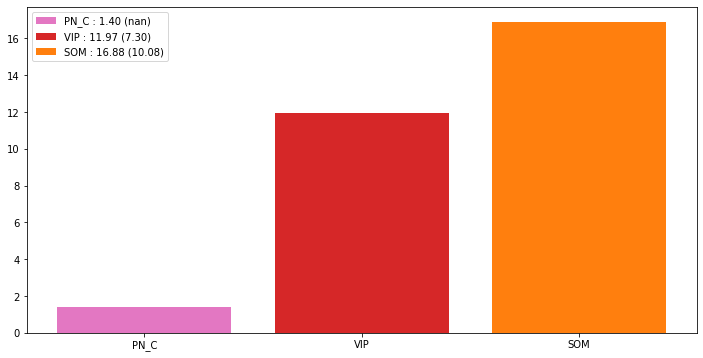

In [10]:
import matplotlib.pyplot as plt
from bmtk.analyzer.compartment import plot_traces
import h5py
import pandas as pd

def spike_frequency_bar_graph(spikes_df, node_set, ms, start=0, end=80000, ax=None, n_bins=10):
    mean = []
    name = []
    labels = []
    for node in node_set:
        cells = range(node['start'], node['end'] + 1)  # +1 to be inclusive of last cell
        cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]

        # skip the first few ms
        cell_spikes = cell_spikes[cell_spikes['timestamps'] > start]
        cell_spikes = cell_spikes[cell_spikes['timestamps'] < end]
        spike_counts = cell_spikes.node_ids.value_counts()
        total_seconds = (ms) / 1000
        spike_counts_per_second = spike_counts / total_seconds

        spikes_mean = spike_counts_per_second.mean()
        spikes_std = spike_counts_per_second.std()

        label = "{} : {:.2f} ({:.2f})".format(node['name'], spikes_mean, spikes_std)
        #print(label)
        c = "tab:" + node['color']
        if ax:
            mean.append(spikes_mean)
            name.append(node['name'])
            labels.append(label)
            ax.bar(node['name'], spikes_mean,label=label,color=c)


    if ax:
        ax.legend()

f = h5py.File('output/spikes.h5','r')
spikes_df = pd.DataFrame({'node_ids':f['spikes']['biophysical']['node_ids'],'timestamps':f['spikes']['biophysical']['timestamps']})
node_set = [
        {"name": "PN_C", "start": 0, "end": 0, "color": "pink"},
        {"name": "VIP", "start": 1, "end": 6, "color": "red"},
        {"name": "SOM", "start": 6, "end": 11, "color": "orange"}
    ]
fig, axs = plt.subplots(1,1,figsize=(12,6))
start1 = 0
end1 = 5000
spike_frequency_bar_graph(spikes_df,node_set,start=start1,end=end1,ax=axs,ms=(end1-start1))

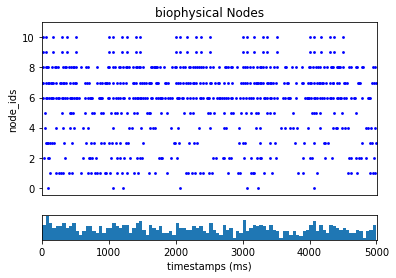

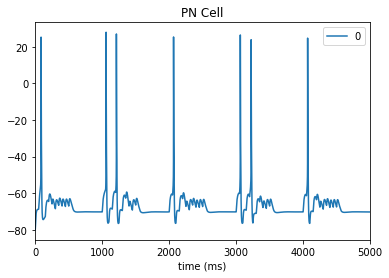

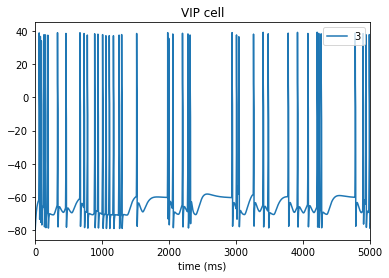

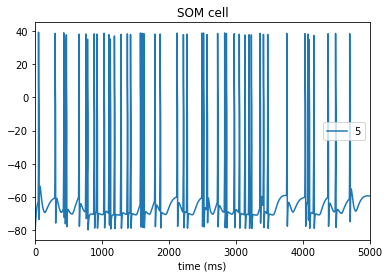

In [11]:
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import plot_raster
plot_raster(config_file='config.json')
plot_traces(report_path='output/v_report.h5',node_ids=[0],title='PN Cell')
plot_traces(report_path='output/v_report.h5',node_ids=[3],title='VIP cell')
plot_traces(report_path='output/v_report.h5',node_ids=[5],title='SOM cell')
plt.show()